In [1]:
import torch
import torch.functional as F


# What Is Scaled Dot Product Attention, Really?
----

Think of attention as a system for finding the most relevant information. 
To do this, it uses three key components for every piece of your input data (like a word in a sentence):

- Query (Q): This is the current word, asking questions like, “Who or what is important to me right now?”

- Key (K): These are all the other words in the sentence, holding labels or keys that say, “This is the information I represent.”

- Value (V): These are also all the other words, but they hold the actual substance or meaning.

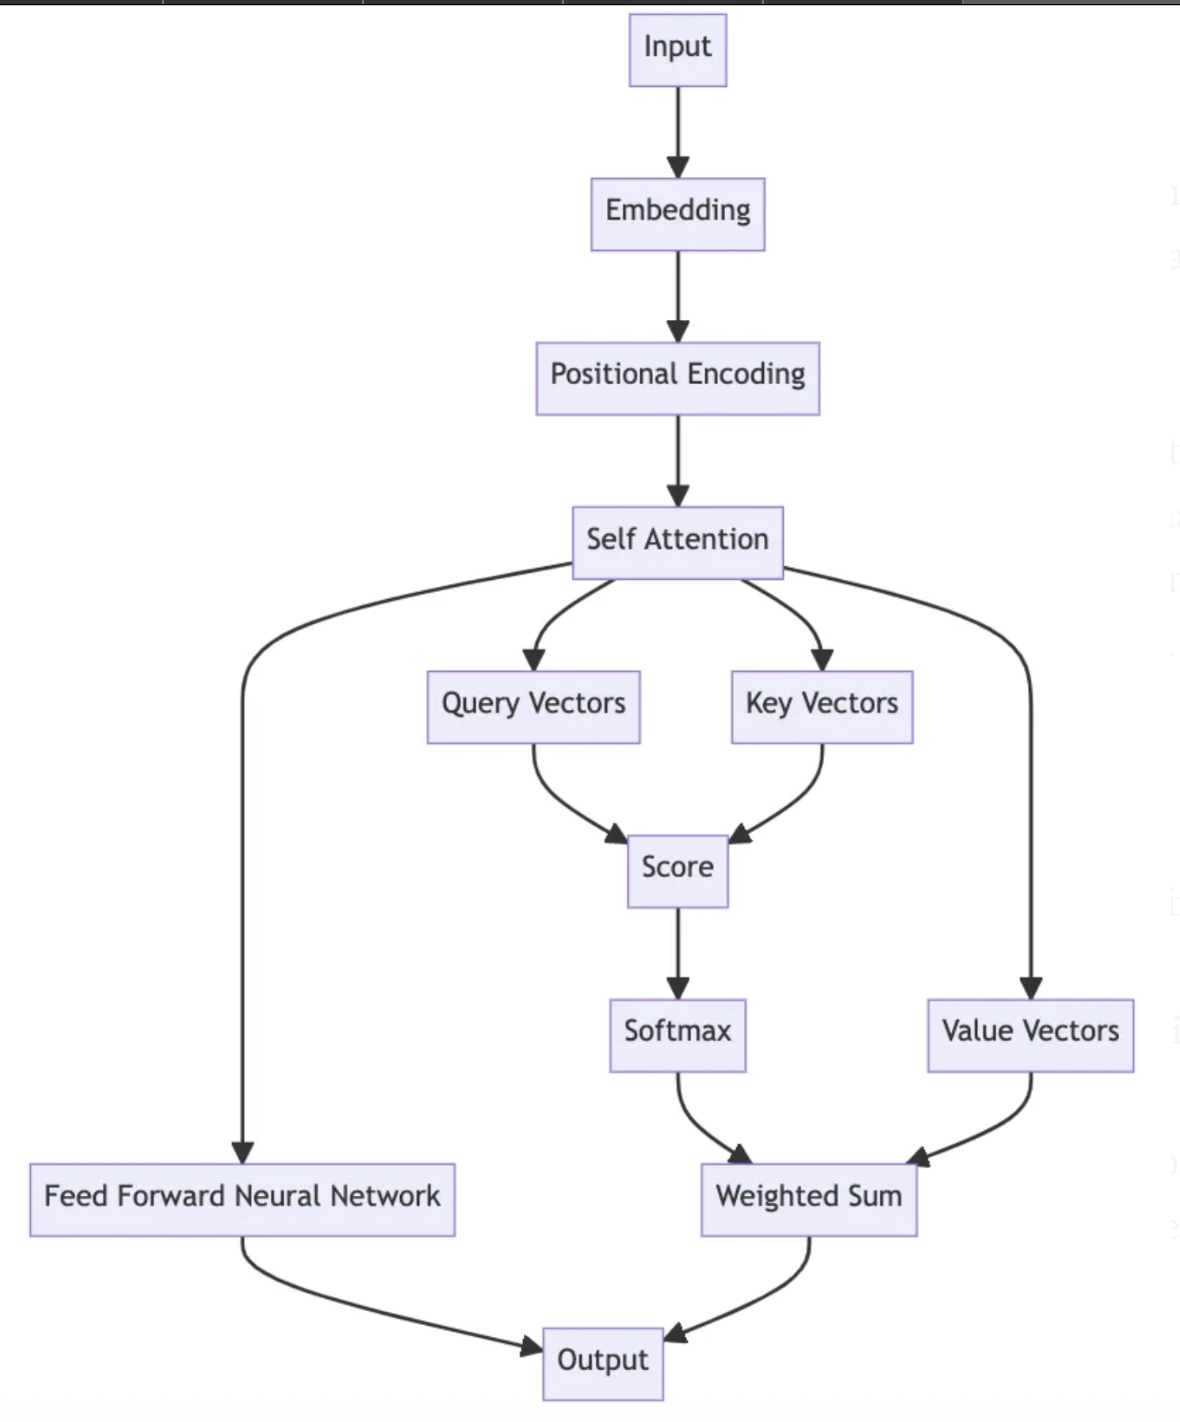

### The process is simple but brilliant:

- The Query from one word is compared against the Key of every other word. This comparison uses a dot product to generate a “similarity score.”

- These scores are scaled down (we’ll see why in a moment) and run through a softmax function to create clean, understandable “attention weights.” 
These weights are percentages that add up to 100%.

- The Value of each word is then multiplied by its attention weight.

- The weighted values are summed up to produce the final output for the query word, a new representation of that word that is now enriched with the context from all the others.


# The "Magic" Ingredient: Why Scaling Matters

When you compute the dot product between two vectors, the result can get very large, especially if the vectors are high-dimensional.

The authors of "Attention is All You Need" introduced a simple, elegant solution: scale the scores down before the softmax. 

They divide the dot product scores by the square root of the dimension of the key vectors (dk).

```Attention(Q,K,V)=softmax(dkQKT)V```

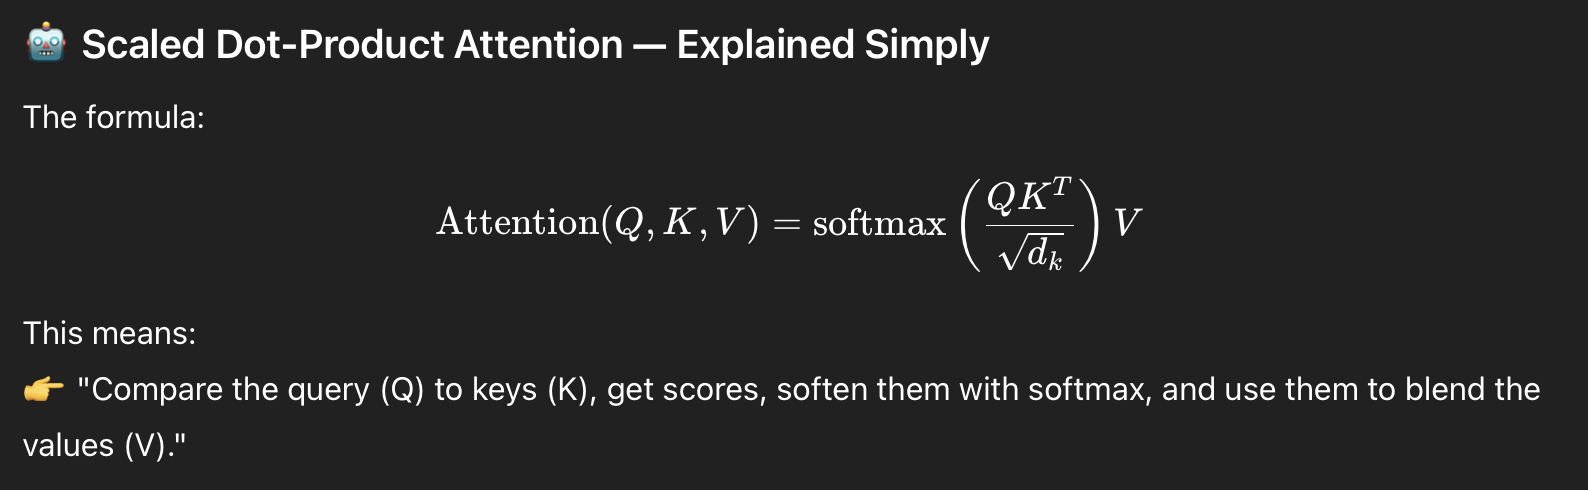



🧠 Core Idea

For each token:
- Q = what I’m looking for (query)
- K = what I have (key)
- V = information to give if matched (value)

We want:
If Q matches K well → use V more.

## 🔍 Step-by-step Process
Let’s say:
We have a sentence with 4 words.

1. Each word is turned into 3 vectors: Q, K, V (all size ```d_k```)

2. Step 1: Compute Dot Product between Q and K
```QK^T = similarity scores between each query and all keys```

3. Step 2: Scale Down the Scores
```scaled_scores = QK^T / sqrt(d_k)```

4. Step 3: Apply Softmax
```attention_weights = softmax(scaled_scores, dim=-1)```

5. Step 4: Multiply by V
```output = attention_weights @ V```

### 🎯 Final Result:

Each output vector is a weighted average of the value vectors, based on how well the query matched the keys.


## ✅ Simple Analogy:

Imagine you're at a party with a question (Q). 
You ask everyone (K) and give more attention to people whose answer matches your question best. 
Then, you gather all their replies (V) into one final answer — weighted by how much you trusted each person.
| Step    | Meaning                                 |
| ------- | --------------------------------------- |
| QKᵀ     | How much each query matches each key    |
| ÷ √dₖ   | Prevent huge scores (stabilize softmax) |
| softmax | Turn scores into attention weights      |
| × V     | Get a weighted average of values        |


In [5]:
# EXAMPLES OF IMPLEMENTING THE ATTENTION MECHANISMS

import torch 

word1 = torch.tensor([1.0, 0.43, 0.94])
word2 = torch.tensor([1.0, 2.0, 0.21])
word3 = torch.tensor([1.2, 3.2, 0.34])

sequence = torch.stack([word1, word2, word3])

print(sequence)

tensor([[1.0000, 0.4300, 0.9400],
        [1.0000, 2.0000, 0.2100],
        [1.2000, 3.2000, 0.3400]])


### 📦 Input Shape

Imagine:
- 1 sentence = batch of 1
- 4 words in that sentence (seq_len = 4)
- Each word has 8-dimensional embedding

In [ ]:
# x.shape = [batch, seq_len, feature_dim]
x = torch.rand(1, 4, 8)  # for example: 1 sentence of 4 words, each with 8 features


In [ ]:
# 📌 Step-by-Step Breakdown with Shapes

# 🔢 ----------------- Step 1: Similarity Scores
# Correct shape manipulation
similarity_scores = torch.matmul(x, x.transpose(1, 2))

# 📐 Shape Explanation:
# x:                   [1, 4, 8]  ← batch x seq_len x features
# x.transpose(1, 2):   [1, 8, 4]  ← batch x features x seq_len

similarity_scores = [1, 4, 8] @ [1, 8, 4] = [1, 4, 4]

# 🤔 What does this mean?
# For every word in the sequence, we now have a similarity score with every other word.
# Example:

# Word 0 → [score to W0, W1, W2, W3]  
# Word 1 → [score to W0, W1, W2, W3]  
# ...


# 🎯 ----------------- Step 2: Softmax
attention_weights = torch.softmax(similarity_scores, dim = -1)
# Shape: [1, 4, 4]
# ===== what this shape tells us that for every batch -> for every word 
# ===== -> we have 4 numbers (each telling us how much importance all the rest of the words have for it)

# Softmax is applied across the 4 tokens (dim=-1), so each row sums to 1.

# Word 1 attends:
# → 40% to word 0  
# → 10% to word 1  
# → 30% to word 2  
# → 20% to word 3


# 🔁 Step 3: Weighted Sum (Attention Output)
# now the attention weights shape was -- [1,4,4]   and the shape of input was -- [1,4,8]
output = torch.matmul(attention_weights, x)
# shape of above output is - [1,4,8]



# ✅ Full Shape Diagram

# Input x: [1, 4, 8]   → 1 sentence, 4 tokens, 8-dim embeddings

# x @ x.T   → similarity_scores: [1, 4, 4]

# softmax   → attention_weights: [1, 4, 4]

# attn_wts @ x → output: [1, 4, 8]  ← same shape as input


In [ ]:
# 💡 Intuition (Hinglish)

# x = sequence of 4 words
# -- Har word ko har word ke saath dot-product karke kitna similar hai yeh check karte ho
# -- Softmax se attention weight nikalte ho
# -- Fir har word ke liye ek naya vector banta hai — using:
# -- “Har dusre word ka vector × uska attention weight”

In [16]:
import torch.nn as nn 
import torch

class SimpleAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: [batch, seq_len, feature_dim]
        
        # Step 1: calculate dot-product similarity
        # [batch, seq_len, feature_dim] × [batch, feature_dim, seq_len] → [batch, seq_len, seq_len]
        similarity_scores = torch.matmul(x, x.transpose(1, 2))

        # Step 2: softmax over last dim (seq_len)
        attention_weights = torch.softmax(similarity_scores, dim=-1)

        # Step 3: attention weights × x → weighted sum of values
        # [batch, seq_len, seq_len] × [batch, seq_len, feature_dim] → [batch, seq_len, feature_dim]
        output = torch.matmul(attention_weights, x)

        return output, attention_weights


In [17]:
x = torch.tensor([
    [
        [1.0, 0.0, 0.0],  # Token A
        [0.0, 1.0, 0.0],  # Token B
        [1.0, 1.0, 0.0],  # Token C
        [0.0, 0.0, 1.0]   # Token D
    ]
])  # shape: [1, 4, 3]

attn = SimpleAttention()
output, weights = attn(x)


In [19]:
import numpy as np

# Helper to print nicely
def show(tensor, title):
    print(f"\n🔹 {title}")
    print(np.round(tensor.detach().numpy(), 2))

# Print Inputs
show(x[0], "Input Word Vectors")

# Similarity scores
scores = torch.matmul(x, x.transpose(1, 2))  # [1, 4, 4]
show(scores[0], "Similarity Scores (Dot Products)")

# Attention Weights
softmax_weights = torch.softmax(scores, dim=-1)
show(softmax_weights[0], "Attention Weights (After Softmax)")

# Output
output = torch.matmul(softmax_weights, x)
show(output[0], "Output Vectors (Weighted Sums)")



🔹 Input Word Vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]

🔹 Similarity Scores (Dot Products)
[[1. 0. 1. 0.]
 [0. 1. 1. 0.]
 [1. 1. 2. 0.]
 [0. 0. 0. 1.]]

🔹 Attention Weights (After Softmax)
[[0.37 0.13 0.37 0.13]
 [0.13 0.37 0.37 0.13]
 [0.2  0.2  0.53 0.07]
 [0.17 0.17 0.17 0.48]]

🔹 Output Vectors (Weighted Sums)
[[0.73 0.5  0.13]
 [0.5  0.73 0.13]
 [0.73 0.73 0.07]
 [0.35 0.35 0.48]]


# 🧠 Part 1: Scaled Dot-Product Attention (SDPA)

🧠 What’s Different?

- Only things added to simple attention
- Separate linear layers for Q, K, V
- Scaling scores by ```1 / sqrt(d_k)```
- Optional masking (we will explain this properly below)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)

    def forward(self, x, mask=None):
        Q = self.q(x)  # [B, S, D]
        K = self.k(x)  # [B, S, D]
        V = self.v(x)  # [B, S, D]

        scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(Q.size(-1), dtype=torch.float32))  # [B, S, S]

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # 🔐 masking step
        # think of it as putting blinders on the model so it can’t “see” certain words.

        attn_weights = F.softmax(scores, dim=-1)  # [B, S, S]
        output = torch.matmul(attn_weights, V)    # [B, S, D]

        return output, attn_weights


## 🎨 Visual Flow (same as before):

```
x → Q, K, V  → [batch, seq_len, dim]

Q × Kᵀ → [batch, seq_len, seq_len] = similarity scores (scaled)

softmax → attention weights

weights × V → final output = [batch, seq_len, dim]
```


## 🛡️ MASKING — Simple Explanation

think of it as putting blinders on the model so it can’t “see” certain words.

1. 📊 What are scores?
    - Shape: [batch, seq_len, seq_len]
    - These are raw similarity values (before softmax)
    - Think of it as:
    - scores[i][j] = how much token i wants to attend to token j

2. 🎭 What is mask?
    - Shape: same as scores → [batch, seq_len, seq_len]
    - It has 1s and 0s:
    - 1 → allow attention
    - 0 → block attention

Example (causal mask for 4 tokens):
```
mask = 
[[[1, 0, 0, 0], 
  [1, 1, 0, 0], 
  [1, 1, 1, 0], 
  [1, 1, 1, 1]]]   # shape = [1, 4, 4]
```

3. 🔐 What does .masked_fill(mask == 0, -inf) do?
- Wherever mask == 0, it replaces that spot in scores with -inf
- This is because:
    - Later, we apply softmax(scores)
    - softmax(-inf) = 0
    - So, model assigns zero attention there

## Example with masking 

In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight
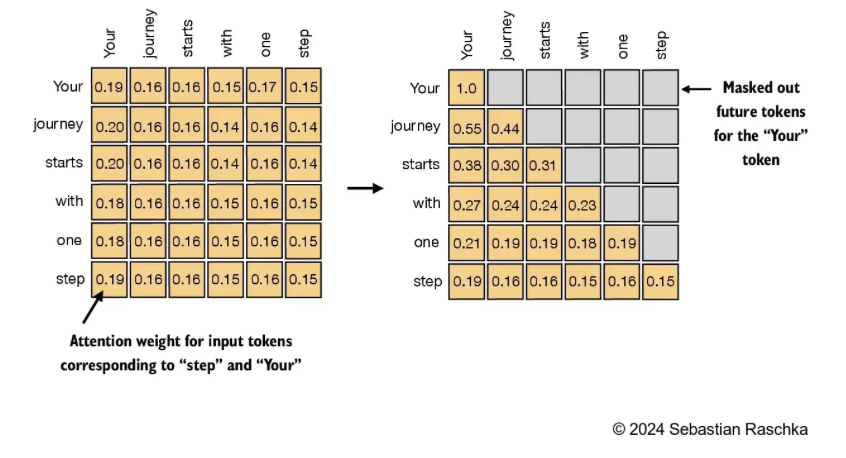

Sure! Below is a clean, simple, ready-to-run PyTorch code that includes:

- Scaled Dot-Product Attention
- Causal Masking
- Full tensor printing to show what’s happening step-by-step

In [ ]:
# ✅ Complete Working Code with Masking

import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V, mask=None):
    # Step 1: Compute dot product Q × Kᵀ
    scores = torch.matmul(Q, K.transpose(-2, -1))  # [B, S, S]
    
    # Step 2: Scale
    d_k = Q.size(-1)
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    
    # Step 3: Apply mask (if any)
    if mask is not None:
        scores = scores.masked_fill_(mask == 0, float('-inf'))

    # Step 4: Softmax
    attn_weights = F.softmax(scores, dim=-1)
    
    # Step 5: Multiply with V
    output = torch.matmul(attn_weights, V)
    
    return output, attn_weights





# 🛡️ Add Causal Mask Function
def create_causal_mask(seq_len):
    # Lower triangle matrix of shape [1, seq_len, seq_len]
    return torch.tril(torch.ones((1, seq_len, seq_len)))






# 🧪 Try It with Example Inputs

# Sequence of 4 tokens, each with 3 features
x = torch.tensor([[
    [1.0, 0.0, 0.0],  # Token 0
    [0.0, 1.0, 0.0],  # Token 1
    [1.0, 1.0, 0.0],  # Token 2
    [0.0, 0.0, 1.0]   # Token 3
]])  # shape: [1, 4, 3]

Q = K = V = x  # using self-attention
mask = create_causal_mask(seq_len=4)

output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)

print("Input:\n", x[0])
print("\nCausal Mask:\n", mask[0])
print("\nAttention Weights:\n", attn_weights[0])
print("\nOutput:\n", output[0])


# Positional Encoding

### 🧠 The Problem: Attention Doesn’t Know Order

["The", "cat", "sat"]  
["sat", "cat", "The"]

Same embeddings, different meaning.
The model has no idea about the order of words.

positional encoding is a technique that is used to give the model some information about the relative positions of the words in the sentences.

| Word  | Position | Original Vector  | Add Positional Info → Final |
| ----- | -------- | ---------------- | --------------------------- |
| "The" | 0        | \[0.2, 0.5, 0.8] | \[0.2+P0, 0.5+P0, 0.8+P0]   |
| "cat" | 1        | \[0.1, 0.4, 0.7] | \[0.1+P1, 0.4+P1, 0.7+P1]   |
| "sat" | 2        | \[0.3, 0.6, 0.9] | \[0.3+P2, 0.6+P2, 0.9+P2]   |

### 🔬 But How Do We Make Positional Vectors?

We calculate one unique vector for every word position in a sentence.
This vector uses sin and cos functions.
For each word at position k and dimension i:

```
Even index (2i) → sin(k / 10000^(2i/d))
Odd index (2i+1) → cos(k / 10000^(2i/d))
```
- k = position of word (0, 1, 2, ...)
- i = column index in embedding (0 to d-1)
- d = total dimension (like 4, 512, etc.)
- n = 10000 = scaler (can be changed but standard is 10000)